<a href="https://colab.research.google.com/github/abhinavarorags/predict/blob/main/predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install statsmodels
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 MB 5.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
import os
import xgboost as xgb

class StockPredictor:
    def __init__(self):
        self.symbols = {'SPX': '^GSPC', 'TSLA': 'TSLA'}
        self.data = self.download_data()
        self.data_plot = {}
        for symbol in self.data:
            df_clone = self.data[symbol].copy(deep=True)
            self.data_plot[symbol] = df_clone.set_index('Date')

    def download_data(self):
        data = {}
        for symbol, ticker in self.symbols.items():
            github_username="abhinavarorags"
            repo_name = "predict"
            branch_name = "main"
            file_path = f"data/{symbol}.csv"
            url = f"https://raw.githubusercontent.com/{github_username}/{repo_name}/{branch_name}/{file_path}"
            print(url)
            # df = pd.read_csv(url, parse_dates=['Date'], index_col='Date')
            df = pd.read_csv(url)
            data[symbol] = df
        return data

    def plot_data(self):
        for symbol, df in self.data_plot.items():
            df['Close'].plot(title=f'{symbol} Closing Prices')
            plt.xlabel('Date')
            plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
            plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))
            plt.xticks(rotation=45)
            plt.ylabel('Close Price')
            plt.show()

    def arima_forecast(self):
        for symbol in self.data:
            df = self.data[symbol]['Close'].dropna()
            # model = ARIMA(df, order=(5,1,0), enforce_stationarity=False, enforce_invertibility=False)
            # model = ARIMA(df, order=(5,1,0), freq='D')
            model = ARIMA(df, order=(5,1,0)) #, freq='D'
            model_fit = model.fit()
            forecast = model_fit.forecast(steps=1)
            print(f"ARIMA Prediction for {symbol} Closing Price on Feb 19: {forecast.iloc[0]:.2f}")

    def random_forest_forecast(self):
        for symbol in self.data:
            df = self.data[symbol]['Close'].dropna()
            df = df.to_frame()
            df['lag_1'] = df['Close'].shift(1)
            df = df.dropna()

            X = df[['lag_1']]
            y = df['Close']
            X_train, y_train = X[:-1], y[:-1]
            X_test = X[-1:].values.reshape(1, -1)

            model = RandomForestRegressor(n_estimators=100, random_state=42)
            model.fit(X_train, y_train)
            prediction = model.predict(X_test)

            print(f"Random Forest Prediction for {symbol} Closing Price on Feb 19: {prediction[0]:.2f}")

    def xgboost_forecast(self):
        for symbol in self.data:
            df = self.data[symbol]['Close'].dropna()
            df = df.to_frame()
            df['lag_1'] = df['Close'].shift(1)
            df = df.dropna()

            X = df[['lag_1']]
            y = df['Close']
            X_train, y_train = X[:-1], y[:-1]
            X_test = X[-1:].values.reshape(1, -1)

            model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
            model.fit(X_train, y_train)
            prediction = model.predict(X_test)

            print(f"XGBoost Prediction for {symbol} Closing Price on Feb 19: {prediction[0]:.2f}")

    def rolling_window_validation(self):
        for symbol, df in self.data.items():
            tscv = TimeSeriesSplit(n_splits=5)
            errors = []
            for train_index, test_index in tscv.split(df['Close']):
                train, test = df['Close'].iloc[train_index], df['Close'].iloc[test_index]
                model = ARIMA(train, order=(5,1,0))
                model_fit = model.fit()
                predictions = model_fit.forecast(steps=len(test))
                rmse = np.sqrt(mean_squared_error(test, predictions))
                errors.append(rmse)

            plt.plot(errors, marker='o', linestyle='-', label=f'{symbol} Rolling RMSE')
            plt.xlabel("Split Index")
            plt.ylabel("RMSE")
            plt.title(f"Rolling Window RMSE for {symbol}")
            plt.legend()
            plt.show()

    def adf_test(self):
        for symbol, df in self.data.items():
            df['Close'] = df['Close'].dropna()
            result = adfuller(df['Close'])
            print(f"ADF Test for {symbol}:")
            print(f"ADF Statistic: {result[0]}")
            print(f"p-value: {result[1]}")
            print("Critical Values:")
            for key, value in result[4].items():
                print(f"   {key}: {value}")
            print("Stationary" if result[1] < 0.05 else "Non-Stationary")

if __name__ == "__main__":
    predictor = StockPredictor()


https://raw.githubusercontent.com/abhinavarorags/predict/main/data/SPX.csv
https://raw.githubusercontent.com/abhinavarorags/predict/main/data/TSLA.csv


In [3]:
predictor.data['SPX'].tail()

,Date,Close,High,Low,Open,Volume
1283,2025-02-10,6066.439941,6073.379883,6044.839844,6046.399902,4458760000
1284,2025-02-11,6068.500000,6076.279785,6042.339844,6049.319824,4324880000
1285,2025-02-12,6051.970215,6063.000000,6003.000000,6025.080078,4627960000
1286,2025-02-13,6115.069824,6116.910156,6050.950195,6060.589844,4763800000
1287,2025-02-14,6114.629883,6127.470215,6107.620117,6115.520020,4335190000


In [4]:
predictor.data['TSLA'].tail()

,Date,Close,High,Low,Open,Volume
1283,2025-02-10,350.730011,362.700012,350.510010,356.209991,77514900
1284,2025-02-11,328.500000,349.369995,325.100006,345.799988,118543400
1285,2025-02-12,336.510010,346.399994,329.119995,329.940002,105382700
1286,2025-02-13,355.940002,358.690002,342.850006,345.000000,89441500
1287,2025-02-14,355.839996,362.000000,347.500000,360.619995,68277300


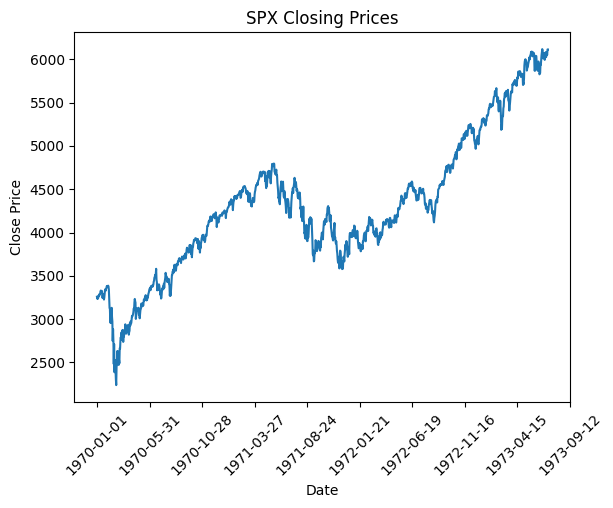

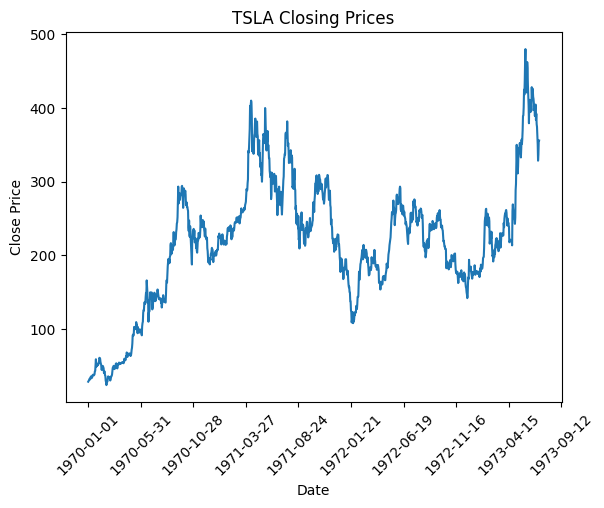

In [5]:
    predictor.plot_data()

In [6]:
    predictor.arima_forecast()

ARIMA Prediction for SPX Closing Price on Feb 19: 6119.46
ARIMA Prediction for TSLA Closing Price on Feb 19: 355.64


In [7]:
  predictor.random_forest_forecast()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Random Forest Prediction for SPX Closing Price on Feb 19: 6075.57
Random Forest Prediction for TSLA Closing Price on Feb 19: 354.37


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [8]:
predictor.xgboost_forecast()

XGBoost Prediction for SPX Closing Price on Feb 19: 6062.16
XGBoost Prediction for TSLA Closing Price on Feb 19: 351.61


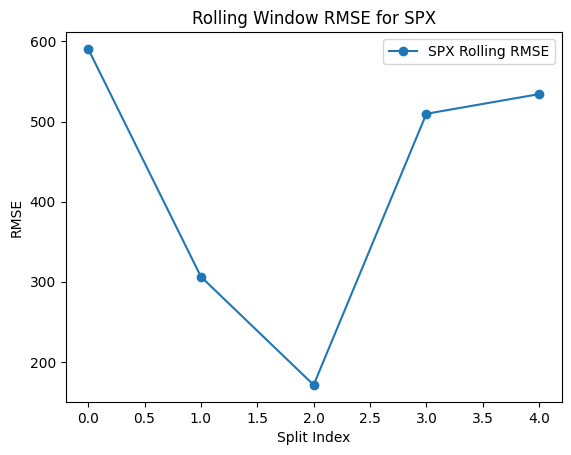

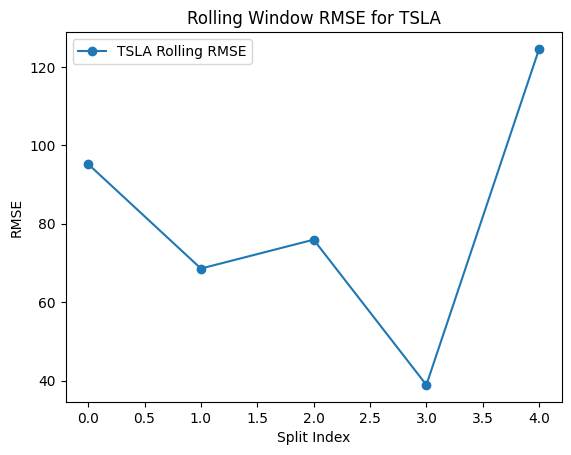

In [9]:
   predictor.rolling_window_validation()

In [10]:
predictor.adf_test()

ADF Test for SPX:
ADF Statistic: -0.0920419985237162
p-value: 0.950225435078717
Critical Values:
   1%: -3.4354811617704835
   5%: -2.8638059672175684
   10%: -2.5679764210546328
Non-Stationary
ADF Test for TSLA:
ADF Statistic: -2.320338639571724
p-value: 0.16549223181190192
Critical Values:
   1%: -3.4354811617704835
   5%: -2.8638059672175684
   10%: -2.5679764210546328
Non-Stationary


In [11]:
print ("Both SPX and TSLA are non-stationary because their p-values are greater than 0.05, meaning we fail to reject the null hypothesis (which assumes non-stationarity). The ADF statistics are also higher than the critical values, further confirming this.  ")

Both SPX and TSLA are non-stationary because their p-values are greater than 0.05, meaning we fail to reject the null hypothesis (which assumes non-stationarity). The ADF statistics are also higher than the critical values, further confirming this.  
